<a href="https://colab.research.google.com/github/moaaz12-web/Transfer-learning-for-tumor-detection/blob/main/VGG_16_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! unzip /content/drive/MyDrive/data/br_detect.zip

# IMPORTING DEPENDENCIES

In [ ]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # -1  to USE CPU
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

get_ipython().magic(u'matplotlib inline')

from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
# from keras.callbacks.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger
# from livelossplot import PlotLossesKeras
from keras.applications import VGG16,VGG19
from keras.models import Model
import os
import zipfile
import glob
import shutil

# DEFINING A FUNCTION TO LOOP OVER EACH IMAGE AND REFINE IT

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

# DEFINING A FUNCTION THAT WILL COLLECT THE IMAGES FROM OUR DATASET, APPLY THE PREVIOUS FUNCTION, AND MAKE INPUTS (X) AND OUTPUTS (Y) 

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y


In [ ]:
folders = ['/content/yes', '/content/no']
img_size = (224,224)

In [ ]:
X,y = load_data(folders, img_size)

# DEFINING A FUNCTION THAT WILL SPLIT THE X AND Y INTO TRAINING, TESTING, AND VALIDATION SET

In [ ]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2100
number of validation examples = 450
number of test examples = 450
X_train shape: (2100, 224, 224, 3)
Y_train shape: (2100, 1)
X_val (dev) shape: (450, 224, 224, 3)
Y_val (dev) shape: (450, 1)
X_test shape: (450, 224, 224, 3)
Y_test shape: (450, 1)


In [ ]:
del X
del y

# DEFINING A FUNCTION TO COMPUTE F1-SCORE

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

# CREATING THE VGG-16 MODEL

In [ ]:
# Loading the VGG model using Transfer Learning
transfer_model = VGG16(include_top = False, weights = 'imagenet',input_shape = (224,224,3))
for layer in transfer_model.layers:
    layer.trainable = False

# Defining the output layers
flat = Flatten()(transfer_model.layers[-1].output)
class1 = Dense(units = 256, activation='relu')(flat)
class2 = Dense(units = 256, activation = 'relu')(class1)
output = Dense(units = 1, activation='sigmoid')(class2)

# define new model
transfer_model = Model(inputs=transfer_model.inputs, outputs=output)

# COMPILE THE MODEL
transfer_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.001),
            metrics=['accuracy'])

# CALLBACKS FOR SAVING THE MODEL

In [ ]:
import time

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))




# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="/cnn_parameters_improvement_{epoch:02d}_{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.35,
                              patience=4, min_lr=0.001)

## TRAINING

In [ ]:
transfer_model.fit(x=X_train, y=y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=[reduce_lr,tensorboard])

Epoch 1/50
17/17 [==============================] - 15s 801ms/step - loss: 3.7062 - accuracy: 0.5124 - val_loss: 0.7734 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 12s 734ms/step - loss: 0.6108 - accuracy: 0.6443 - val_loss: 0.6584 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 12s 737ms/step - loss: 0.6243 - accuracy: 0.6757 - val_loss: 0.6515 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 13s 760ms/step - loss: 0.5019 - accuracy: 0.7329 - val_loss: 0.5169 - val_accuracy: 0.6978 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 13s 761ms/step - loss: 0.3837 - accuracy: 0.8167 - val_loss: 1.8382 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 13s 754ms/step - loss: 0.4206 - accuracy: 0.8295 - val_loss: 0.3602 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 13s 758ms/st

# SAVING MODEL TO DRIVE

In [ ]:
from keras.models import load_model

transfer_model.save('/content/drive/MyDrive/data/saved_model_latest_latest.h5')  # creates a HDF5 file 'my_model.h5' in ur google drive

# model = tf.keras.models.load_model('/content/drive/MyDrive/data/saved_model_7_latest_tired.h5')


In [ ]:
history = transfer_model.history.history

for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy
lr


# PLOT EVALUATION METRICS

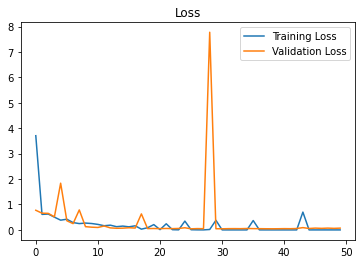

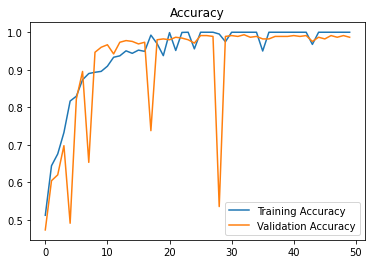

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()




plot_metrics(history)

In [ ]:
transfer_model.metrics_names


['loss', 'accuracy']

# EVALUATION ON VALIDATION DATA

In [ ]:
loss, acc = transfer_model.evaluate(x=X_val, y=y_val)


15/15 [==============================] - 6s 208ms/step - loss: 0.0699 - accuracy: 0.9867


In [ ]:
print ("Validation Loss = {}".format(loss))
print ("Validation Accuracy = {}%".format(np.around(acc*100)))

Validation Loss = 0.0699150338768959
Validation Accuracy = 99.0%


# PREDICTIONS ON TESTING DATA

In [ ]:
y_test_prob = transfer_model.predict(X_test)
y_test_prob

15/15 [==============================] - 2s 158ms/step


array([[6.91962532e-09],
       [6.91448010e-09],
       [1.00000000e+00],
       [4.22872081e-02],
       [6.84322421e-09],
       [7.29792702e-12],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.41894455e-10],
       [1.50651103e-10],
       [1.72675118e-06],
       [1.00000000e+00],
       [2.17192081e-07],
       [1.00000000e+00],
       [1.03829667e-09],
       [4.15862855e-09],
       [1.00000000e+00],
       [9.99998927e-01],
       [9.50544000e-01],
       [9.99817789e-01],
       [5.06373459e-12],
       [9.99986649e-01],
       [6.71248529e-07],
       [7.11151271e-09],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [5.15551794e-12],
       [5.24684207e-09],
       [3.16678026e-08],
       [1.44504829e-12],
       [4.09640307e-07],
       [6.76005811e-08],
       [2.63161297e-07],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [3.41086678e-04],
       [3.72904693e-11],
       [5.89162369e-07],


In [ ]:
y_test_hat_rounded = np.around(y_test_prob)   # this would convert [0.87, 0.13] to [1., 0.]
y_test_hat_rounded

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],

# F1-SCORE ON TESTING DATA

In [ ]:
f1score = compute_f1_score(y_test, y_test_hat_rounded)


In [ ]:
f1score*100

96.71361502347418

# GENERAL INFO ABOUT THE DATASET

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [ ]:
y = np.concatenate((y_train, y_test, y_val), axis=0)
data_percentage(y)

Number of examples:3000
Percentage of positive examples: 50.0%, number of pos examples: 1500
Percentage of negative examples: 50.0%, number of neg examples: 1500


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:2100
Percentage of positive examples: 49.80952380952381%, number of pos examples: 1046
Percentage of negative examples: 50.19047619047619%, number of neg examples: 1054
Validation Data:
Number of examples:450
Percentage of positive examples: 53.55555555555556%, number of pos examples: 241
Percentage of negative examples: 46.44444444444444%, number of neg examples: 209
Testing Data:
Number of examples:450
Percentage of positive examples: 47.333333333333336%, number of pos examples: 213
Percentage of negative examples: 52.666666666666664%, number of neg examples: 237


# MAKING PREDICTIONS ON IMAGES

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving download.jpeg to download.jpeg


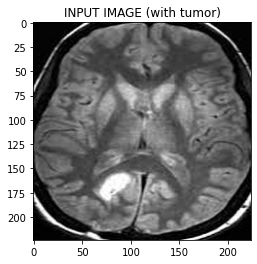

In [ ]:
image = cv2.imread('/content/download.jpeg')

image = crop_brain_contour(image, plot=False)


image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

image = image / 255.

plt.imshow(image)

plt.title("INPUT IMAGE (with tumor)");

In [ ]:

res = transfer_model.predict( np.array( [image,] )  )


1/1 [==============================] - 1s 684ms/step


In [ ]:
if res[0] > 0.5:
  print(f"The input image has tumor with {res[0][0]*100}% accuracy")
else:
  print(f"The input image has no tumor with {(1 - res[0][0])*100}% accuracy")

The input image has tumor with 99.97230172157288% accuracy
